# Imports

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import timm

# Config

In [2]:
class CFG:
    seed = 888
    debug = False
    one_fold = False
    base_dir = pathlib.Path("/kaggle/input/hms-harmful-brain-activity-classification")
    path_train = base_dir / "train.csv"
    spec_dir = base_dir / "train_spectrograms"
    transform = transforms.Resize((512, 512), antialias=False)
    model_name = "tf_efficientnet_b0_ns"
    n_fold = 5
    epochs = 6
    batch_size = 10    
    lr = 0.001

# Load data
- We classify the spectrogram directly.
- As a label we use the aggregated the votes per spectrogram slice

In [3]:
train_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")
train_df

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


In [4]:
label_columns = train_df.filter(like="_vote").columns.to_list()
label_columns

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']

In [5]:
data = train_df.groupby("spectrogram_id")[label_columns].sum()
n = data.sum(axis=1)
for x in label_columns:
    data[x] = data[x] / n
data["path"] = data.index.map(lambda x: CFG.spec_dir / f"{x}.parquet")
data = data.reset_index()
data

,spectrogram_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,path
0,353733,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
1,924234,0.000000,0.0000,0.454545,0.000000,0.090909,0.454545,/kaggle/input/hms-harmful-brain-activity-class...
2,999431,0.000000,0.0625,0.000000,0.875000,0.000000,0.062500,/kaggle/input/hms-harmful-brain-activity-class...
3,1084844,0.000000,0.0000,0.000000,1.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
4,1219001,0.677419,0.0000,0.322581,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
...,...,...,...,...,...,...,...,...
11133,2146188334,0.000000,0.0000,0.000000,0.000000,0.000000,1.000000,/kaggle/input/hms-harmful-brain-activity-class...
11134,2146414988,0.000000,1.0000,0.000000,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
11135,2146798838,0.000000,0.5000,0.000000,0.111111,0.000000,0.388889,/kaggle/input/hms-harmful-brain-activity-class...
11136,2147312808,0.000000,1.0000,0.000000,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...


# Data Handling
- Spectrogram is loaded, which contains spectrograms in 4 different regions.
- All together they are clipped, log-transformed and the standardized.
- Finally it is resized as an image.
- Note, since the spectrograms have sometimes very different lenghts this creates a certain distortion.

In [6]:
from torch.utils.data import Dataset, DataLoader

In [7]:
def preprocess(x):
    x = np.clip(x, np.exp(-6), np.exp(10))
    x = np.log(x)
    m, s = x.mean(), x.std()
    x = (x - m) / (s + 1e-6)
    return x


class SpecDataset(Dataset):
    
    def __init__(self, df, transform=CFG.transform):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        # input
        x = pd.read_parquet(row.path)
        x = x.fillna(-1).values[:, 1:].T
        x = preprocess(x)
        x = torch.Tensor(x[None, :])
        if self.transform:
            x = self.transform(x)
        # output
        y = np.array(row.loc[label_columns].values, 'float32')
        y = torch.Tensor(y)
        return x, y

In [8]:
ds = SpecDataset(df=data.iloc[:50])
ds, len(ds)

(<__main__.SpecDataset at 0x78580079a9b0>, 50)

In [9]:
x, y = ds[0]
x.shape, x, y.shape, y

(torch.Size([1, 512, 512]),
 tensor([[[ 1.2054,  1.0713,  0.9173,  ...,  1.0850,  1.0003,  0.9526],
          [ 1.6161,  1.3790,  1.0838,  ...,  1.1306,  1.0802,  1.0625],
          [ 1.7601,  1.6410,  1.4847,  ...,  1.2272,  1.1640,  1.1396],
          ...,
          [-0.8010, -0.6403, -0.4212,  ..., -0.8658, -1.1458, -1.3737],
          [-0.7389, -0.5765, -0.3597,  ..., -0.8116, -1.2053, -1.5185],
          [-0.8025, -0.5923, -0.3145,  ..., -0.8211, -1.2874, -1.6645]]]),
 torch.Size([6]),
 tensor([1., 0., 0., 0., 0., 0.]))

In [10]:
ld = DataLoader(dataset=ds, batch_size=CFG.batch_size, drop_last=True, num_workers=os.cpu_count())
ld, len(ld)

(<torch.utils.data.dataloader.DataLoader at 0x785800627dc0>, 5)

In [11]:
x, y = next(iter(ld))
x.shape, x, y.shape, y

(torch.Size([10, 1, 512, 512]),
 tensor([[[[ 1.2054,  1.0713,  0.9173,  ...,  1.0850,  1.0003,  0.9526],
           [ 1.6161,  1.3790,  1.0838,  ...,  1.1306,  1.0802,  1.0625],
           [ 1.7601,  1.6410,  1.4847,  ...,  1.2272,  1.1640,  1.1396],
           ...,
           [-0.8010, -0.6403, -0.4212,  ..., -0.8658, -1.1458, -1.3737],
           [-0.7389, -0.5765, -0.3597,  ..., -0.8116, -1.2053, -1.5185],
           [-0.8025, -0.5923, -0.3145,  ..., -0.8211, -1.2874, -1.6645]]],
 
 
         [[[ 1.8998,  1.8514,  1.7770,  ...,  1.5049,  1.6229,  1.6995],
           [ 1.9068,  1.8645,  1.7993,  ...,  1.5456,  1.6550,  1.7260],
           [ 1.9491,  1.8969,  1.8166,  ...,  1.5353,  1.6585,  1.7386],
           ...,
           [-0.9747, -0.9018, -0.7895,  ..., -1.1577, -1.2446, -1.3011],
           [-0.9120, -0.8630, -0.7876,  ..., -1.2038, -1.3935, -1.5167],
           [-0.7837, -0.7837, -0.7837,  ..., -1.0045, -1.5825, -1.9580]]],
 
 
         [[[ 1.1971,  1.0295,  0.7975,  ...,  1.

# Model

In [12]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"DEVICE: {DEVICE}")

DEVICE: cuda


In [13]:
torch.cuda.memory_allocated()

0

In [14]:
## Alternative in timm
# model = timm.create_model(model_name=CFG.model_name, pretrained=True, num_classes=6, in_chans=1)
# model.to(DEVICE)
# num_parameter = sum(x.numel() for x in model.parameters())
# print(f"Model has {num_parameter} parameters.")

In [15]:
import torch
from torchvision import models

model = models.resnet18(pretrained=True)

model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

num_classes = 6
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Calculate the number of parameters
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model 'resnet18' has {num_parameters} parameters.")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


Model 'resnet18' has 11173318 parameters.


In [16]:
y_out = model(x.to(DEVICE))
y_out

tensor([[-0.7480, -1.0296, -0.5986, -0.5065,  0.0636,  0.7551],
        [-0.4471, -0.0395, -1.1119, -0.6061, -0.1154,  0.1015],
        [-0.5526, -0.8931, -0.2866,  0.2375,  0.4450,  0.8745],
        [-0.8281, -0.3145, -0.6806, -0.7373,  0.1968,  0.8242],
        [-0.4416, -0.1155, -0.8498, -1.0694,  0.0582,  0.6813],
        [-0.6804, -0.8218, -0.3255, -0.7697, -0.0497,  0.3495],
        [-0.4960, -0.6980, -0.6441, -0.0904, -0.1575,  0.2746],
        [-0.7736, -0.4017, -0.6071, -0.2670, -0.1758,  0.8449],
        [-0.8858, -0.6752, -0.8718, -0.4821,  0.3873,  0.7041],
        [-0.2886, -0.1195, -0.7600, -0.3795,  0.3152,  1.0670]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

# Training Utils
- Create Kullback-Leibler Divergence loss from logits.
- Compute loss utility.

In [17]:
def KLDivLoss(logit, target):
    log_prob = F.log_softmax(logit, dim=1)
    return F.kl_div(log_prob, target, reduction="batchmean")

In [18]:
# from reference
def KL_loss(p,q):
    epsilon=10**(-15)
    p=torch.clip(p,epsilon,1-epsilon)
    q = nn.functional.log_softmax(q,dim=1)
    return torch.mean(torch.sum(p*(torch.log(p)-q),dim=1))

In [19]:
KLDivLoss(y_out, y.to(DEVICE)), KL_loss(p=y.to(DEVICE), q=y_out)

(tensor(1.3212, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.3212, device='cuda:0', grad_fn=<MeanBackward0>))

In [20]:
def compute_loss(model, data_loader):
    model.eval()
    l_loss = []
    with torch.no_grad():
        for x, y in data_loader:
            y_pred = model(x.to(DEVICE))
            loss = KLDivLoss(y_pred, y.to(DEVICE))
            l_loss.append(loss.item())
    return np.mean(l_loss) 

In [21]:
compute_loss(model, ld)

1.4089637756347657

In [22]:
torch.cuda.memory_allocated()

1192086528

In [23]:
del model, x, y, y_out
torch.cuda.empty_cache()

In [24]:
torch.cuda.memory_allocated()

1192076288

# Training
- Uses plain 5 fold training strategy.
- Runs for all epochs and checkpoints model weights if the validation loss improves.

In [25]:
from sklearn.model_selection import KFold

In [26]:
if CFG.debug:
    data = data.iloc[:400]

In [27]:
def train(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=CFG.epochs, DEVICE=DEVICE):
    best_loss = float("inf")
    history = []
    for epoch in tqdm(range(epochs)):
        model.train()
        l_loss = []
        for x, y in tqdm(train_dataloader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred = model(x)
            loss = KLDivLoss(y_pred, y)
            l_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_loss = np.mean(l_loss)
        valid_loss = compute_loss(model, val_dataloader)
        history.append((epoch, train_loss, valid_loss))
        print(f"Epoch {epoch}")
        print(f"Train Loss: {train_loss:>10.6f}, Valid Loss: {valid_loss:>10.6}")
        if valid_loss < best_loss:
            print(f"Loss improves from {best_loss:>10.6f} to {valid_loss:>10.6}")
            torch.save(model.state_dict(), f"{CFG.model_name}__{fold}.pt")
            best_loss = valid_loss
    print(f"\nBest loss Model training with {best_loss}\n")
    l_best_loss.append(best_loss)
    
    # plot
    history = pd.DataFrame(history, columns=["epoch", "loss", "val_loss"]).set_index("epoch")
    history.plot(subplots=True, layout=(1, 2), sharey="row", figsize=(14, 6))
    plt.show()


Fold 0:


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.934573, Valid Loss:      0.728
Loss improves from        inf to      0.728


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.667052, Valid Loss:   0.676307
Loss improves from   0.728000 to   0.676307


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.597113, Valid Loss:   0.661358
Loss improves from   0.676307 to   0.661358


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.551131, Valid Loss:    0.60126
Loss improves from   0.661358 to    0.60126


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.502823, Valid Loss:   0.604022


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.458546, Valid Loss:   0.607225

Best loss Model training with 0.6012597775646389



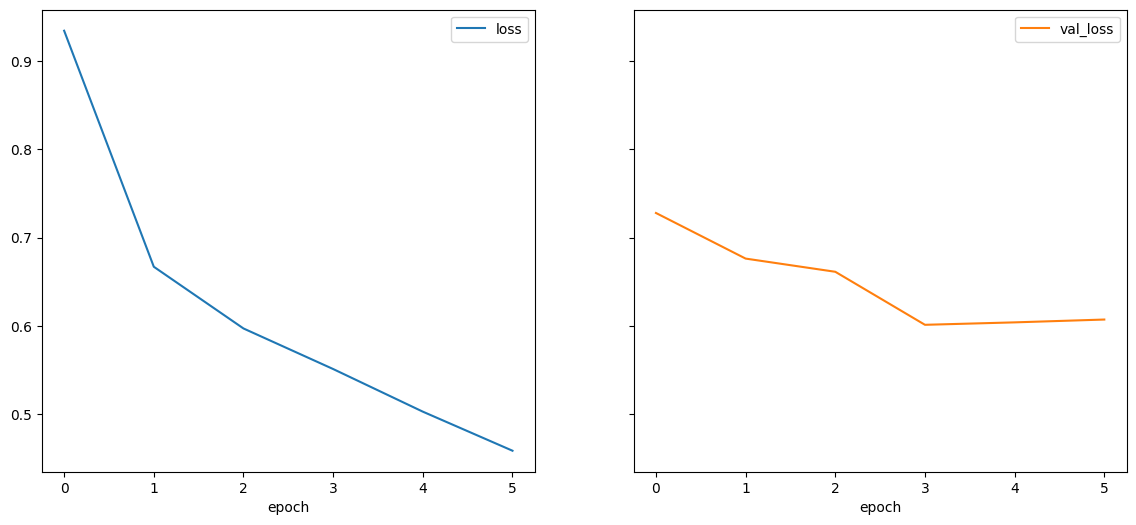

Fold 1:


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.924253, Valid Loss:   0.786577
Loss improves from        inf to   0.786577


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.670620, Valid Loss:   0.633161
Loss improves from   0.786577 to   0.633161


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.590532, Valid Loss:   0.603304
Loss improves from   0.633161 to   0.603304


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.533732, Valid Loss:   0.633923


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.494471, Valid Loss:   0.662798


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.441639, Valid Loss:    0.67926

Best loss Model training with 0.6033042194196462



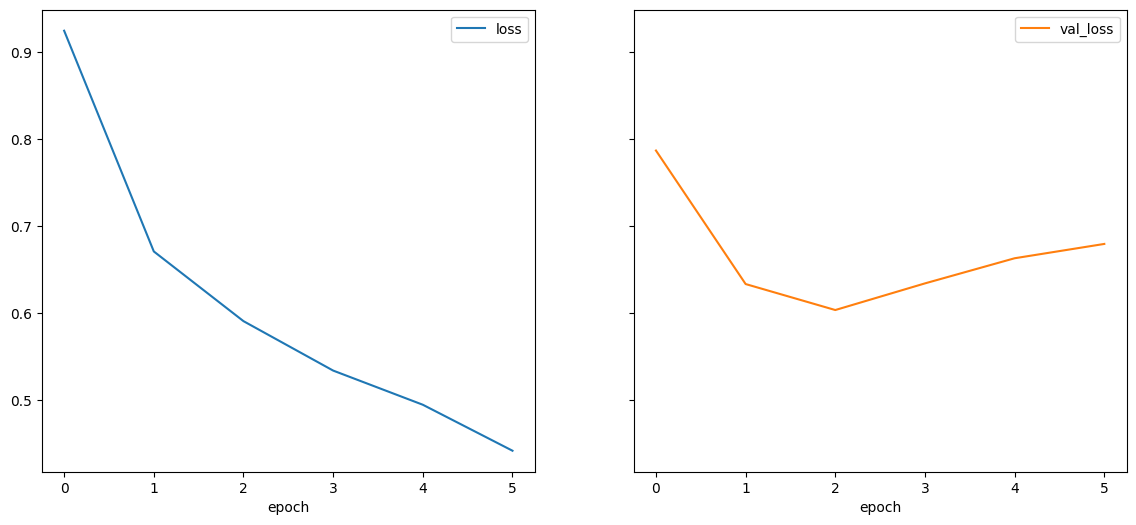

Fold 2:


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.909487, Valid Loss:   0.761585
Loss improves from        inf to   0.761585


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.687701, Valid Loss:   0.610653
Loss improves from   0.761585 to   0.610653


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.604310, Valid Loss:   0.621679


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.561255, Valid Loss:   0.601026
Loss improves from   0.610653 to   0.601026


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.508718, Valid Loss:   0.590367
Loss improves from   0.601026 to   0.590367


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.454859, Valid Loss:   0.592035

Best loss Model training with 0.5903672975542299



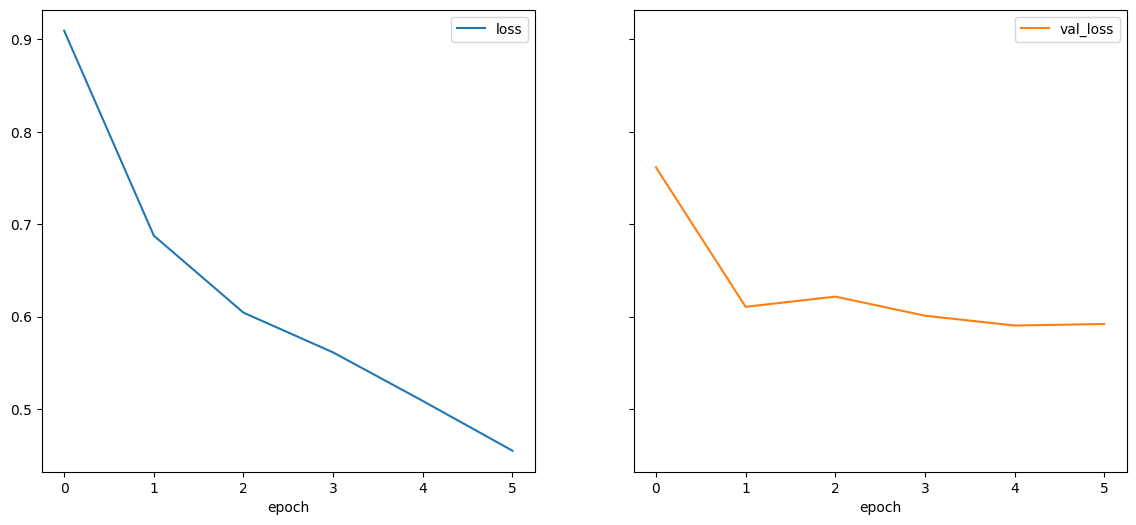

Fold 3:


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.919227, Valid Loss:   0.708021
Loss improves from        inf to   0.708021


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.669889, Valid Loss:   0.621608
Loss improves from   0.708021 to   0.621608


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.600673, Valid Loss:   0.682009


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.544404, Valid Loss:   0.649037


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.504654, Valid Loss:   0.623911


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.442633, Valid Loss:   0.668653

Best loss Model training with 0.621608094717355



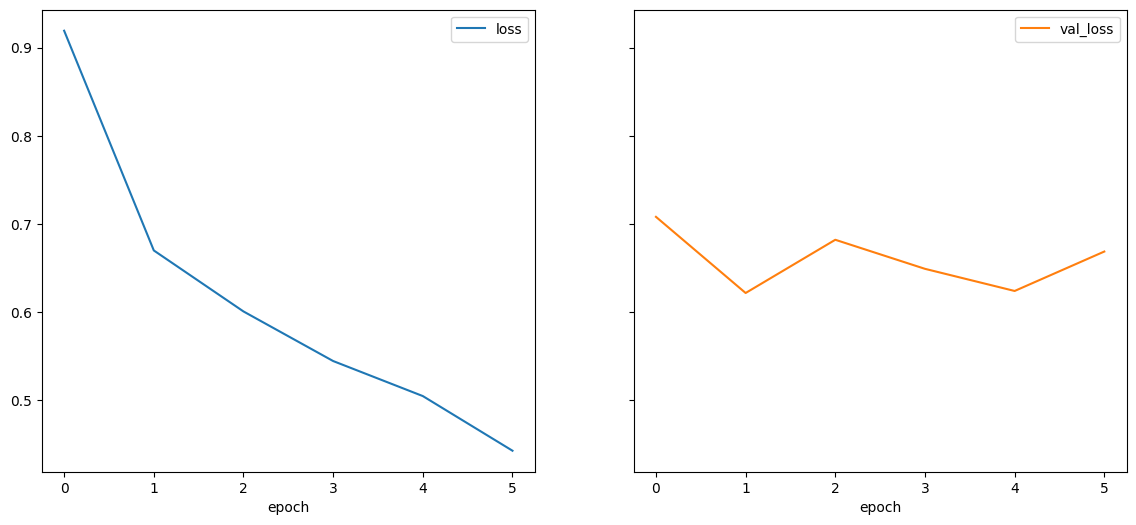

Fold 4:


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.929435, Valid Loss:   0.685086
Loss improves from        inf to   0.685086


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.679123, Valid Loss:   0.602134
Loss improves from   0.685086 to   0.602134


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.602932, Valid Loss:   0.580129
Loss improves from   0.602134 to   0.580129


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.557009, Valid Loss:   0.630742


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.505223, Valid Loss:   0.555933
Loss improves from   0.580129 to   0.555933


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.451990, Valid Loss:   0.586954

Best loss Model training with 0.5559333904976268



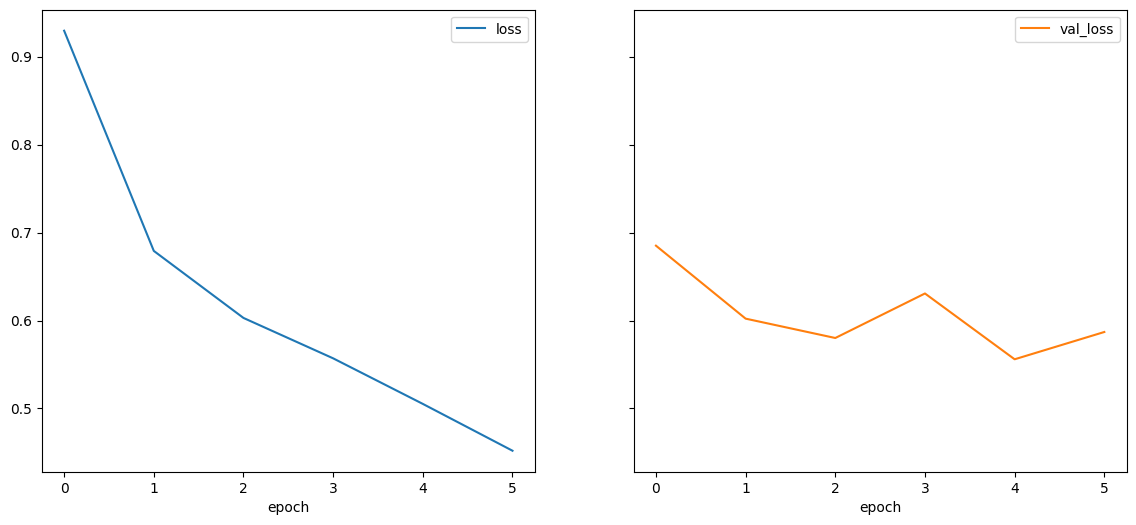

CPU times: user 1h 22min 24s, sys: 3min 51s, total: 1h 26min 15s
Wall time: 2h 17min 2s


In [28]:
%%time
"""
The KFold object from scikit-learn is used to split the dataset into CFG.n_fold subsets.
Each subset is used once as a validation set while the remaining subsets form the training set.
This is repeated CFG.n_fold times, and the average result is used to estimate the model's performance.
"""
kf = KFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

l_best_loss = []
for fold, (iloc_train, iloc_valid) in enumerate(kf.split(data)):
    print(f"Fold {fold}:")

    # prepare data
    train_ds = SpecDataset(df=data.iloc[iloc_train])
    valid_ds = SpecDataset(df=data.iloc[iloc_valid])
    train_dataloader = DataLoader(dataset=train_ds, shuffle=True, batch_size=CFG.batch_size, num_workers=os.cpu_count(), drop_last=True)
    val_dataloader = DataLoader(dataset=valid_ds, batch_size=CFG.batch_size, num_workers=os.cpu_count())
    
    # init training
    model = timm.create_model(model_name=CFG.model_name, pretrained=True, num_classes=6, in_chans=1)
    model.to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=CFG.epochs)
    optimizer, scheduler

    
    train(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=CFG.epochs, DEVICE=DEVICE)
    
    if CFG.one_fold:
        break

# OOF

In [29]:
l_best_loss, np.mean(l_best_loss)

([0.6012597775646389,
  0.6033042194196462,
  0.5903672975542299,
  0.621608094717355,
  0.5559333904976268],
 0.5944945559506993)

# Notes and useful info/functions

In [30]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
            #    accuracy_fn,
               device: torch.device = device):
    train_loss, train_hits, train_acc, all_y_true, all_y_pred = 0, 0, 0, [], []
    model.to(device)
    model.train()
    
    for batch in dataloader:
        X, y = batch
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels
        train_loss += loss
        train_acc += acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

In [31]:
def test_step(dataloader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for batch in dataloader:
            X, y = batch
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss, test_acc

In [32]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

train_time_start = timer()


def train(model: torch.nn.Module,
         train_data: torch.utils.data.DataLoader,
         test_data: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
        #  accuracy_fn,
         epochs: int,
         device:torch.device = device,
         model_loss_and_acc: pd.DataFrame = None):

   if model_loss_and_acc is None:
       model_loss_and_acc = pd.DataFrame(columns=['train_loss', 'train_acc', 'test_loss', 'test_acc', "f1_score"])

   for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                     data_loader=train_data,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                    #  accuracy_fn=accuracy_fn,
                                     device=device)
        test_loss, test_acc, f1_score = test_step(model=model,
                                     data_loader=test_data,
                                     loss_fn=loss_fn,
                                    #  accuracy_fn=accuracy_fn,
                                     device=device)

        new_row = pd.Series({'train_loss': train_loss, 'train_acc': train_acc, 'test_loss': test_loss, 'test_acc': test_acc, "f1_score": f1_score})
        model_loss_and_acc.loc[len(model_loss_and_acc.index)] = new_row

   train_time_end = timer()
   print(f"\nTraining was done in {(train_time_end - train_time_start):.5f} seconds")

   return model_loss_and_acc